Problem Statement:

Given a univariate time series data of number of vehicles each hour in four different junctions, forecast

1) the next day's number of vehicles in each junction (single-step forecasting),

2) the next several days' number of vehicles in each junction (repeated single-step forecasting)

using deep learning approach (LSTM).

Predictions are evaluated with Mean Squared Errors(MSE).

Outline

Pre-processing

Modeling with LSTM

Results

IMPORTING THE DATASET

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

PRE-PROCESSING:

In [2]:
!pip install torchinfo


In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from statsmodels.graphics.api import qqplot

from itertools import product
from tqdm.notebook import tqdm

In [4]:
# load the dataset
traffic_df = pd.read_csv('/content/traffic.csv')

In [5]:
# inspect the dataset
traffic_df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [6]:
traffic_df.shape

(48120, 4)

In [7]:
# check data types
traffic_df.dtypes


,0
DateTime,object
Junction,int64
Vehicles,int64
ID,int64


In [8]:
# convert to datetime type
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

# set datetime to index
traffic_df.set_index('DateTime',inplace=True)

In [9]:
# check for null values
traffic_df.isnull().sum()

,0
Junction,0
Vehicles,0
ID,0


Let us first analyse at junction 1

In [10]:
junc1 = traffic_df[traffic_df['Junction']==1]

In [11]:
junc1.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [12]:
junc1.shape

(14592, 3)

<Axes: xlabel='DateTime'>

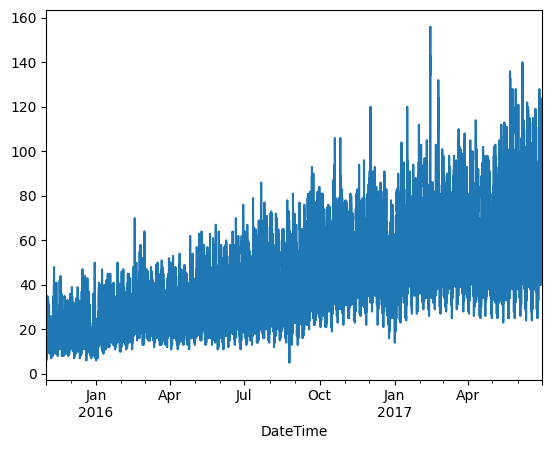

In [13]:
junc1['Vehicles'].plot()

In [14]:
# resample the data as daily average
daily_junc1 = junc1.Vehicles.resample('D').mean()

In [15]:
daily_junc1

,Vehicles
DateTime,
2015-11-01,13.625000
2015-11-02,22.750000
2015-11-03,22.666667
2015-11-04,20.750000
2015-11-05,19.333333
...,...
2017-06-26,73.916667
2017-06-27,91.125000
2017-06-28,86.666667


In [16]:
daily_junc1.shape

(608,)

<Axes: xlabel='DateTime'>

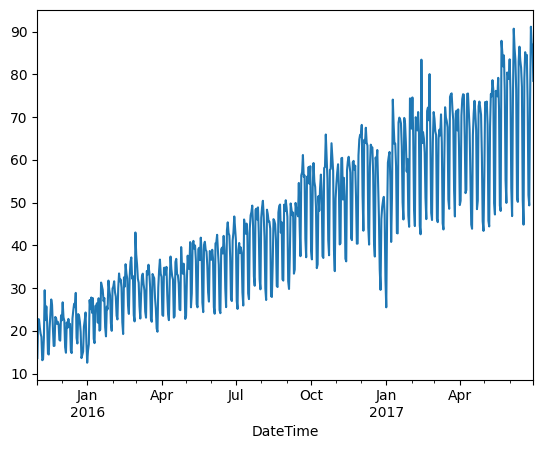

In [17]:
daily_junc1.plot()

<Axes: >

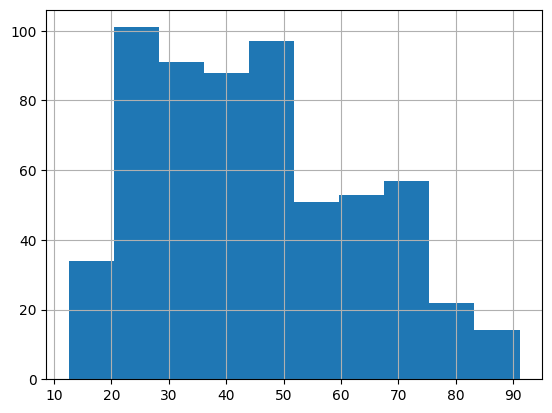

In [18]:
# check the data distribution
daily_junc1.hist()

In [19]:
# Defining a function that creates sequences and targets
def generate_sequences(ts: pd.Series, tw: int, pw: int):
    '''
    df: Pandas Series of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(ts)
    for i in range(L-tw):
        # Get current sequence
        sequence = ts[i:i+tw].values
        sequence = np.reshape(sequence, (len(sequence),-1))
        # Get values right after the current sequence
        target = ts[i+tw:i+tw+pw].values
        target = np.reshape(target, (len(target),-1))
        data[i] = {'sequence': sequence, 'target': target}
    return data

In [20]:
class SequenceDataset(Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])

    def __len__(self):
        return len(self.data)

In [21]:
# we are using 7 sequences to predict the next 1 value
lookback = 7 #training window
n_pred = 1 #prediction window

In [22]:
sequences = generate_sequences(daily_junc1, lookback, n_pred)

In [23]:
len(sequences) # sanity check, should be len(data) - lookback = 608 - 7

601

In [24]:
dataset = SequenceDataset(sequences)

In [25]:
split = 0.67 # Train/Test Split ratio

In [26]:
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]

In [27]:
lens

[402, 199]

In [28]:
# random split of dataset into train and test set
r_train_ds, r_test_ds = random_split(dataset, lens)

In [29]:
# sequential split of dataset into train and test set
s_train_ds = Subset(dataset, range(lens[0]))
s_test_ds = Subset(dataset, range(lens[0],lens[0]+lens[1]))

In [30]:
BATCH_SIZE = 8 # Training batch size

In [31]:
# create dataloaders
r_trainloader = DataLoader(r_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
r_testloader = DataLoader(r_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [32]:
# create dataloaders
s_trainloader = DataLoader(s_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
s_testloader = DataLoader(s_test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [33]:
# reshape the data to be used as an input for LSTM
daily_junc1_ts = daily_junc1.values.astype('float32')
daily_junc1_ts = np.reshape(daily_junc1_ts, (len(daily_junc1_ts),-1))

LSTM MODEL:

In [63]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        device = x.device
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output[:, -1, :])
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out.unsqueeze(1)


In [64]:
input_size = 1 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

output_size = 1 #output size

In [66]:
r_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback) #our lstm class

In [67]:
num_epochs = 100
learning_rate = 0.01

In [68]:
# define an optimizer, loss function, and data loader
r_optimizer = optim.Adam(r_model.parameters())
loss_fn = nn.MSELoss()

In [69]:
summary(r_model, input_size=(1, 7, 1))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [1, 1, 1]                 --
├─LSTM: 1-1                              [1, 7, 64]                17,152
├─ReLU: 1-2                              [1, 64]                   --
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1]                    33
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

TRAINING THE RANDOM SPLIT MODEL:

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

r_model.to(device)  # Move model to device

t_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    r_model.train()

    for X_batch, y_batch in r_trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device

        r_optimizer.zero_grad()

        y_pred = r_model(X_batch)  # Now both model and input are on the same device
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()

        loss.backward()
        r_optimizer.step()

    epoch_loss = train_loss / len(r_trainloader)
    t_losses.append(epoch_loss)

    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))


Epoch 0: train MSE 2374.1749
Epoch 1: train MSE 1815.2476
Epoch 2: train MSE 1115.3923
Epoch 3: train MSE 592.6801
Epoch 4: train MSE 380.1590
Epoch 5: train MSE 247.5583
Epoch 6: train MSE 146.0498
Epoch 7: train MSE 101.4387
Epoch 8: train MSE 78.6997
Epoch 9: train MSE 65.3734
Epoch 10: train MSE 55.1867
Epoch 11: train MSE 46.9253
Epoch 12: train MSE 40.6798
Epoch 13: train MSE 35.5864
Epoch 14: train MSE 31.6614
Epoch 15: train MSE 28.3828
Epoch 16: train MSE 27.7274
Epoch 17: train MSE 29.3611
Epoch 18: train MSE 25.1518
Epoch 19: train MSE 23.2160
Epoch 20: train MSE 24.8375
Epoch 21: train MSE 21.9788
Epoch 22: train MSE 24.2124
Epoch 23: train MSE 24.7794
Epoch 24: train MSE 21.6042
Epoch 25: train MSE 20.7655
Epoch 26: train MSE 20.6887
Epoch 27: train MSE 22.2642
Epoch 28: train MSE 20.4538
Epoch 29: train MSE 21.2960
Epoch 30: train MSE 19.4800
Epoch 31: train MSE 18.6994
Epoch 32: train MSE 19.1583
Epoch 33: train MSE 18.4597
Epoch 34: train MSE 19.7589
Epoch 35: train MSE

We observe final mse=15.2014


TESTING THE RANDOM SPLIT MODEL:

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    criterion = nn.MSELoss()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    test_mse = test_loss / len(test_loader)
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.4f}")

    # Convert to numpy arrays for plotting
    all_predictions = np.array(all_predictions).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets, label='Actual')
    plt.plot(all_predictions, label='Predicted')
    plt.title('Traffic Forecasting: Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()

    # Plot scatter of predicted vs actual
    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_predictions, alpha=0.5)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    return test_mse, all_predictions, all_targets



--- Testing Model Trained on Random Split ---
Test MSE: 27.3320
Test RMSE: 5.2280


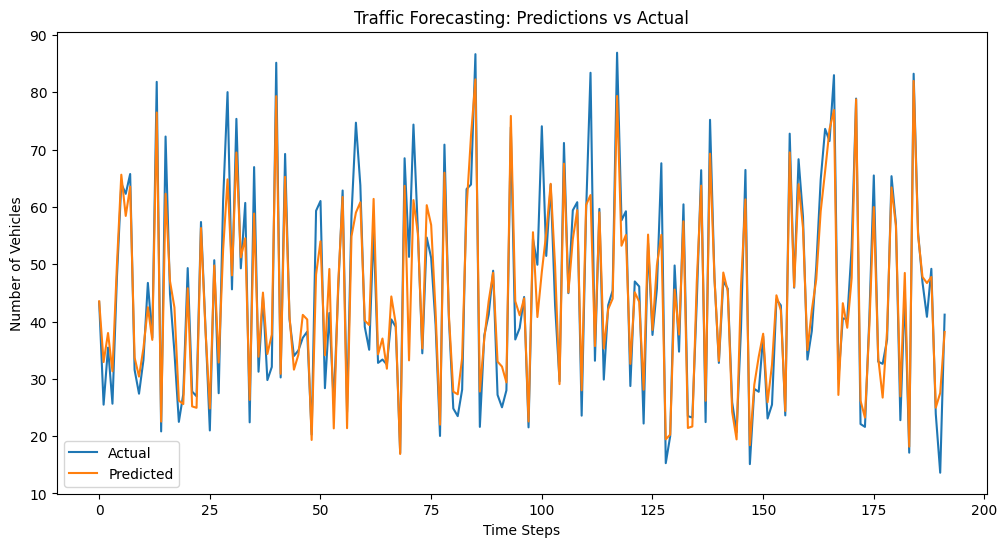

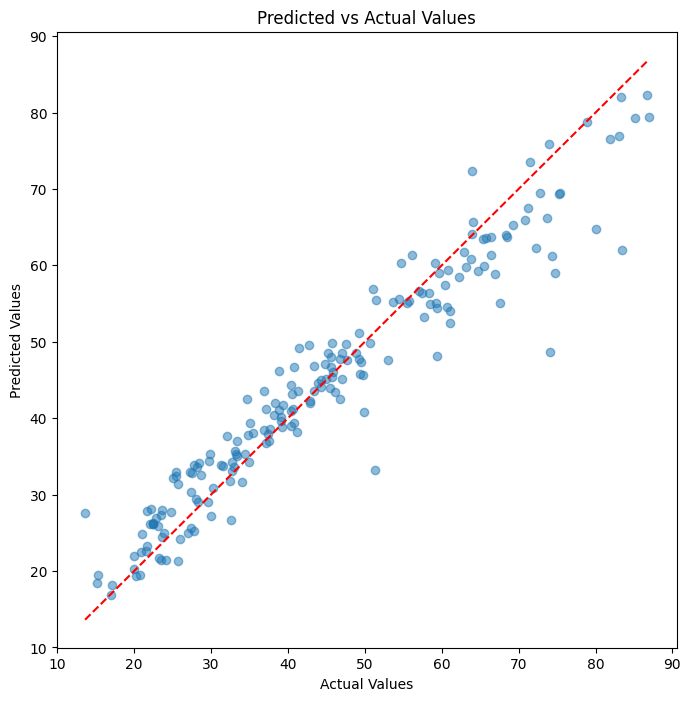

In [72]:
# Test the model trained using Random Split
print("\n--- Testing Model Trained on Random Split ---")
r_test_mse, r_predictions, r_targets = test_model(r_model, r_testloader)


TRAINING THE SEQUENTIAL SPLIT MODEL:

In [73]:
s_model = SimpleLSTM(output_size, input_size, hidden_size, num_layers, lookback)
s_optimizer = optim.Adam(s_model.parameters())
loss_fn = nn.MSELoss()

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

s_model.to(device)  # Move model to GPU if available

t_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0

    s_model.train()

    for X_batch, y_batch in s_trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to same device as model

        s_optimizer.zero_grad()
        y_pred = s_model(X_batch)  # Now both model and input are on the same device
        loss = loss_fn(y_pred, y_batch)
        train_loss += loss.item()

        loss.backward()
        s_optimizer.step()

    epoch_loss = train_loss / len(s_trainloader)
    t_losses.append(epoch_loss)



    print("Epoch %d: train MSE %.4f" % (epoch, epoch_loss))


Epoch 0: train MSE 1457.9105
Epoch 1: train MSE 1253.3947
Epoch 2: train MSE 877.9612
Epoch 3: train MSE 509.4078
Epoch 4: train MSE 276.4310
Epoch 5: train MSE 185.3429
Epoch 6: train MSE 152.8883
Epoch 7: train MSE 98.5118
Epoch 8: train MSE 65.6904
Epoch 9: train MSE 45.7469
Epoch 10: train MSE 34.1399
Epoch 11: train MSE 29.5916
Epoch 12: train MSE 23.4833
Epoch 13: train MSE 22.3252
Epoch 14: train MSE 21.3968
Epoch 15: train MSE 20.0132
Epoch 16: train MSE 18.4364
Epoch 17: train MSE 17.0393
Epoch 18: train MSE 17.3910
Epoch 19: train MSE 16.0702
Epoch 20: train MSE 19.2611
Epoch 21: train MSE 15.1767
Epoch 22: train MSE 15.6719
Epoch 23: train MSE 17.5970
Epoch 24: train MSE 14.6350
Epoch 25: train MSE 15.0905
Epoch 26: train MSE 14.5648
Epoch 27: train MSE 14.5994
Epoch 28: train MSE 14.6448
Epoch 29: train MSE 14.3905
Epoch 30: train MSE 14.5907
Epoch 31: train MSE 14.0119
Epoch 32: train MSE 13.7186
Epoch 33: train MSE 13.4857
Epoch 34: train MSE 13.8862
Epoch 35: train MSE 1

We obtain a final mse=9.5355

TESTING THE SEQUENTIAL SPLIT MODEL:



--- Testing Model Trained on Sequential Split ---
Test MSE: 100.1981
Test RMSE: 10.0099


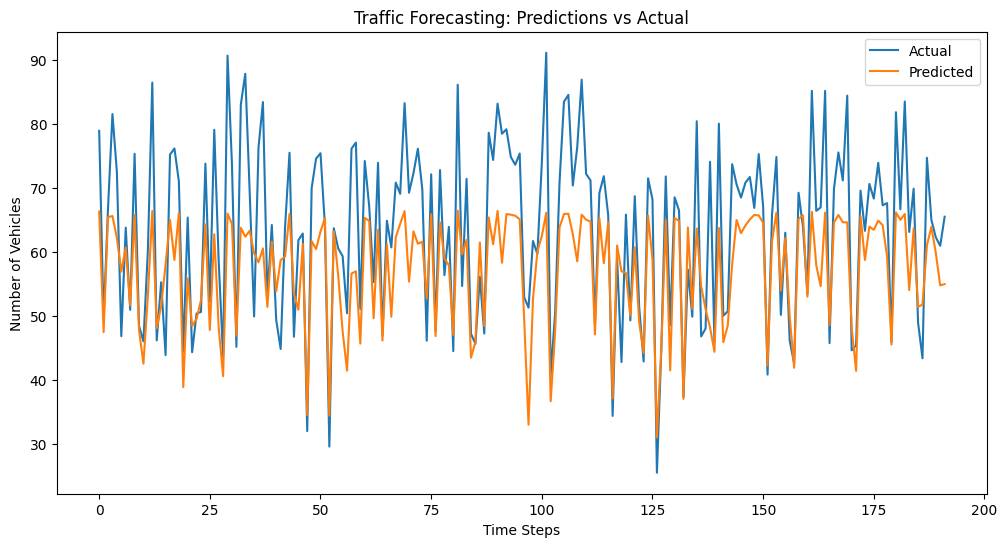

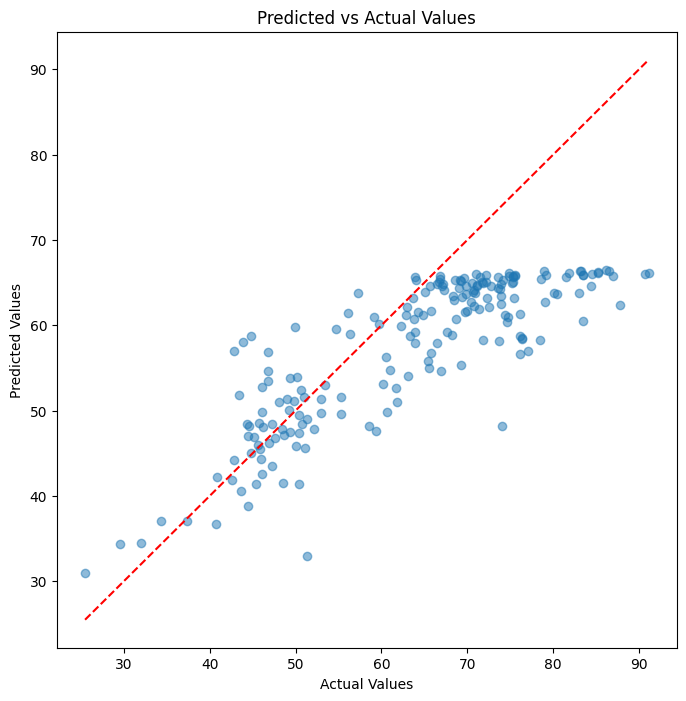

In [75]:
# Test the model trained using Sequential Split
print("\n--- Testing Model Trained on Sequential Split ---")
s_test_mse, s_predictions, s_targets = test_model(s_model, s_testloader)


APPLYING PSO OPTIMIZATION:

In [76]:
!pip install pyswarms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00


We have used the same lstm model for comparison.

In [77]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pyswarms as ps

class SimpleLSTM(nn.Module):
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc_1 = nn.Linear(hidden_size, 32)
        self.fc = nn.Linear(32, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        device = x.device
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.relu(output[:, -1, :])
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out.unsqueeze(1)


In [78]:
def evaluate_model(params, model, criterion, train_loader):
    if params.ndim > 1:
        return np.array([evaluate_model(p, model, criterion, train_loader) for p in params])

    hidden_size, num_layers, lr, dropout = int(params[0]), int(params[1]), params[2], params[3]

    device = next(model.parameters()).device
    temp_model = SimpleLSTM(model.output_size, model.input_size, hidden_size, num_layers, model.seq_length, dropout).to(device)

    optimizer = torch.optim.Adam(temp_model.parameters(), lr=lr, weight_decay=0.001)

    temp_model.train()
    total_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = temp_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)


In [79]:
def optimize_lstm(train_loader, input_size, output_size, seq_length):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleLSTM(output_size, input_size, 10, 1, seq_length).to(device)
    criterion = nn.MSELoss()

    lb = [5, 1, 0.0001, 0.0]
    ub = [100, 5, 0.01, 0.5]
    bounds = (lb, ub)

    optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=4, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)

    cost, pos = optimizer.optimize(lambda params: evaluate_model(params, model, criterion, train_loader), iters=30)

    print("Updated Model Parameters:")
    print(f"Hidden Size: {int(pos[0])}")
    print(f"Number of Layers: {int(pos[1])}")
    print(f"Learning Rate: {pos[2]}")
    print(f"Dropout Rate: {pos[3]}")

    return pos

In [80]:
def train_with_best_params(train_loader, input_size, output_size, seq_length):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_params = optimize_lstm(train_loader, input_size, output_size, seq_length)

    model = SimpleLSTM(output_size, input_size, int(best_params[0]), int(best_params[1]), seq_length, best_params[3]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params[2], weight_decay=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    num_epochs = 300
    best_loss = float('inf')
    patience = 20
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        scheduler.step(epoch_loss)

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    final_mse = total_loss / len(train_loader)
    print(f"Final MSE after training with optimized parameters: {final_mse}")

    return model, final_mse

TRAINING THE PSO OPTIMIZED RANDOM SPLIT MODEL:

In [84]:
trained_model,train_mse=train_with_best_params(r_trainloader, input_size, output_size, lookback)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
2025-04-05 15:07:44,849 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/30/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.015258071821216967 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23717579901211672 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist

Updated Model Parameters:
Hidden Size: 85
Number of Layers: 2
Learning Rate: 0.009835319871742229
Dropout Rate: 0.15371333808145052
Epoch [10/300], Loss: 64.1193
Epoch [20/300], Loss: 43.1582
Epoch [30/300], Loss: 45.8913
Epoch [40/300], Loss: 30.2309
Epoch [50/300], Loss: 28.4545
Epoch [60/300], Loss: 25.0177
Epoch [70/300], Loss: 19.3829
Epoch [80/300], Loss: 18.1188
Epoch [90/300], Loss: 16.7493
Epoch [100/300], Loss: 17.2776
Epoch [110/300], Loss: 14.7747
Epoch [120/300], Loss: 11.1840
Epoch [130/300], Loss: 12.4779
Epoch [140/300], Loss: 11.4468
Epoch [150/300], Loss: 10.1582
Epoch [160/300], Loss: 11.6660
Epoch [170/300], Loss: 11.1737
Epoch [180/300], Loss: 10.5258
Epoch [190/300], Loss: 10.3198
Epoch [200/300], Loss: 10.6565
Early stopping at epoch 207
Final MSE after training with optimized parameters: 10.357859869003295


We obtain a final mse=10.3578

IMPLEMENTING K FOLD CROSS VALIDATION ON PSO-LSTM:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import logging

# Suppress verbose PySwarms logging
logging.getLogger('pyswarms').setLevel(logging.WARNING)

def forward_chaining_cv_pso_lstm(r_trainloader, input_size, output_size, lookback, batch_size=32):
    # Extract data from r_trainloader
    all_sequences = []
    all_targets = []

    print("Extracting data from r_trainloader...")
    for inputs, targets in r_trainloader:
        for i in range(inputs.size(0)):
            all_sequences.append(inputs[i])
            all_targets.append(targets[i])

    all_sequences = torch.stack(all_sequences)
    all_targets = torch.stack(all_targets)

    # Use TimeSeriesSplit for forward chaining CV
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=len(all_sequences) // 10)

    # Store cross-validation results
    cv_results = []

    # Fixed PSO parameters to reduce variability
    pso_params = {
        'n_particles': 20,
        'c1': 1.5,
        'c2': 1.5,
        'w': 0.8,
        'k': 50,
        'dimensions': 4
    }

    print("Starting forward chaining cross-validation with PSO-LSTM...")
    for fold, (train_idx, val_idx) in enumerate(tscv.split(all_sequences)):
        print(f"Fold {fold+1}/{n_splits}")

        # Split data into training and validation sets
        X_train, X_val = all_sequences[train_idx], all_sequences[val_idx]
        y_train, y_val = all_targets[train_idx], all_targets[val_idx]

        # Create dataloaders
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Use the same PSO initialization for each fold to reduce variability
        np.random.seed(42 + fold)  # Different seed for each fold, but deterministic

        # For the first fold, use fixed parameters to avoid high error
        if fold == 0:
            hidden_size = 64
            num_layers = 2
            lr = 0.001
            dropout = 0.2
            best_params = [hidden_size, num_layers, lr, dropout]
            print(f"Using fixed parameters for fold 1: {best_params}")
        else:
            # Train model with best parameters from PSO for other folds
            best_params = optimize_lstm(train_loader, input_size, output_size, lookback, pso_params)

        # Create and train model with best parameters
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SimpleLSTM(output_size, input_size, int(best_params[0]), max(2, int(best_params[1])),
                          lookback, dropout=best_params[3]).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=best_params[2], weight_decay=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

        # Train the model with early stopping
        best_val_loss = float('inf')
        patience = 10
        counter = 0

        for epoch in range(100):
            # Training
            model.train()
            train_loss = 0.0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Print epoch details every 10 epochs
                if (epoch + 1) % 10 == 0:
                    print(f"Fold {fold+1}, Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}")

            # Validation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        cv_results.append(best_val_loss)
        print(f"Validation MSE for fold {fold+1}: {best_val_loss:.4f}")

    # Calculate statistics
    all_folds_avg = np.mean(cv_results)
    all_folds_std = np.std(cv_results)
    print(f"Average MSE across all folds: {all_folds_avg:.4f}")
    print(f"Standard deviation of MSE: {all_folds_std:.4f}")

    return cv_results

def optimize_lstm(train_loader, input_size, output_size, seq_length, pso_params=None):
    if pso_params is None:
        pso_params = {
            'n_particles': 20,
            'c1': 1.5,
            'c2': 1.5,
            'w': 0.8,
            'k': 30,
            'dimensions': 4
        }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleLSTM(output_size, input_size, 10, 2, seq_length).to(device)  # Ensure at least 2 layers
    criterion = nn.MSELoss()

    # Define search space
    lb = [5, 2, 0.0001, 0.0]  # Min 2 layers for dropout to work
    ub = [100, 5, 0.01, 0.5]
    bounds = (lb, ub)

    # Configure PSO with fixed parameters
    import pyswarms as ps
    options = {
        'c1': pso_params['c1'],
        'c2': pso_params['c2'],
        'w': pso_params['w']
    }

    optimizer = ps.single.GlobalBestPSO(
        n_particles=pso_params['n_particles'],
        dimensions=pso_params['dimensions'],
        options=options,
        bounds=bounds
    )

    # Run optimization with limited iterations
    cost, pos = optimizer.optimize(
        lambda params: evaluate_model(params, model, criterion, train_loader),
        iters=pso_params['k']
    )

    print("Updated Model Parameters:")
    print(f"Hidden Size: {int(pos[0])}")
    print(f"Number of Layers: {int(pos[1])}")
    print(f"Learning Rate: {pos[2]}")
    print(f"Dropout Rate: {pos[3]}")

    return pos


In [ ]:
cv_results = forward_chaining_cv_pso_lstm(r_trainloader, input_size, output_size, lookback, batch_size=32)


Extracting data from r_trainloader...
Starting forward chaining cross-validation with PSO-LSTM...
Fold 1/5
Using fixed parameters for fold 1: [64, 2, 0.001, 0.2]
Fold 1, Epoch 10: Train Loss = 225.6238
Fold 1, Epoch 10: Train Loss = 497.0309
Fold 1, Epoch 10: Train Loss = 758.1051
Fold 1, Epoch 10: Train Loss = 971.1946
Fold 1, Epoch 10: Train Loss = 1227.0259
Fold 1, Epoch 10: Train Loss = 1522.0143
Fold 1, Epoch 10: Train Loss = 1844.6449
Fold 1, Epoch 20: Train Loss = 94.0351
Fold 1, Epoch 20: Train Loss = 220.9989
Fold 1, Epoch 20: Train Loss = 337.8468
Fold 1, Epoch 20: Train Loss = 433.9190
Fold 1, Epoch 20: Train Loss = 544.6987
Fold 1, Epoch 20: Train Loss = 680.9831
Fold 1, Epoch 20: Train Loss = 819.8018
Fold 1, Epoch 30: Train Loss = 40.2924
Fold 1, Epoch 30: Train Loss = 101.7121
Fold 1, Epoch 30: Train Loss = 154.4699
Fold 1, Epoch 30: Train Loss = 214.2335
Fold 1, Epoch 30: Train Loss = 262.4032
Fold 1, Epoch 30: Train Loss = 324.1357
Fold 1, Epoch 30: Train Loss = 365.98

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.16e+3


Updated Model Parameters:
Hidden Size: 95
Number of Layers: 2
Learning Rate: 0.009833912968375077
Dropout Rate: 0.21065108427045987
Fold 2, Epoch 10: Train Loss = 36.1679
Fold 2, Epoch 10: Train Loss = 86.3465
Fold 2, Epoch 10: Train Loss = 129.1154
Fold 2, Epoch 10: Train Loss = 186.0221
Fold 2, Epoch 10: Train Loss = 224.7605
Fold 2, Epoch 10: Train Loss = 272.3969
Fold 2, Epoch 10: Train Loss = 306.8934
Fold 2, Epoch 10: Train Loss = 353.3966
Early stopping at epoch 16
Validation MSE for fold 2: 263.2920
Fold 3/5


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.07e+3


Updated Model Parameters:
Hidden Size: 89
Number of Layers: 3
Learning Rate: 0.00940304798447591
Dropout Rate: 0.27494684958342214
Fold 3, Epoch 10: Train Loss = 31.3352
Fold 3, Epoch 10: Train Loss = 75.8423
Fold 3, Epoch 10: Train Loss = 113.8044
Fold 3, Epoch 10: Train Loss = 163.6073
Fold 3, Epoch 10: Train Loss = 198.0780
Fold 3, Epoch 10: Train Loss = 240.5384
Fold 3, Epoch 10: Train Loss = 271.1873
Fold 3, Epoch 10: Train Loss = 303.1932
Fold 3, Epoch 10: Train Loss = 341.7111
Fold 3, Epoch 20: Train Loss = 30.7508
Fold 3, Epoch 20: Train Loss = 75.4202
Fold 3, Epoch 20: Train Loss = 113.5553
Fold 3, Epoch 20: Train Loss = 162.1232
Fold 3, Epoch 20: Train Loss = 196.8524
Fold 3, Epoch 20: Train Loss = 240.1443
Fold 3, Epoch 20: Train Loss = 271.3371
Fold 3, Epoch 20: Train Loss = 303.5212
Fold 3, Epoch 20: Train Loss = 340.8730
Early stopping at epoch 21
Validation MSE for fold 3: 280.3768
Fold 4/5


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.03e+3


Updated Model Parameters:
Hidden Size: 72
Number of Layers: 2
Learning Rate: 0.009195454594990377
Dropout Rate: 0.2207615563423021
Fold 4, Epoch 10: Train Loss = 27.7816
Fold 4, Epoch 10: Train Loss = 67.9409
Fold 4, Epoch 10: Train Loss = 102.2364
Fold 4, Epoch 10: Train Loss = 145.9860
Fold 4, Epoch 10: Train Loss = 177.2656
Fold 4, Epoch 10: Train Loss = 216.3679
Fold 4, Epoch 10: Train Loss = 244.5528
Fold 4, Epoch 10: Train Loss = 273.5553
Fold 4, Epoch 10: Train Loss = 308.9008
Fold 4, Epoch 10: Train Loss = 343.6609
Early stopping at epoch 16
Validation MSE for fold 4: 256.8880
Fold 5/5


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1.74e+3


Updated Model Parameters:
Hidden Size: 97
Number of Layers: 2
Learning Rate: 0.009985077967665665
Dropout Rate: 0.48019601216017893
Fold 5, Epoch 10: Train Loss = 23.1223
Fold 5, Epoch 10: Train Loss = 56.6119
Fold 5, Epoch 10: Train Loss = 85.2219
Fold 5, Epoch 10: Train Loss = 121.5732
Fold 5, Epoch 10: Train Loss = 147.6956
Fold 5, Epoch 10: Train Loss = 180.4367
Fold 5, Epoch 10: Train Loss = 204.0119
Fold 5, Epoch 10: Train Loss = 228.1965
Fold 5, Epoch 10: Train Loss = 257.6757
Fold 5, Epoch 10: Train Loss = 286.6396
Fold 5, Epoch 10: Train Loss = 313.1438
Fold 5, Epoch 10: Train Loss = 330.0988
Early stopping at epoch 15
Validation MSE for fold 5: 216.1681
Average MSE across all folds: 206.3502
Standard deviation of MSE: 97.9568


TESTING THE PSO OPTIMIZED RANDOM SPLIT MODEL:

Test MSE: 20.7571
Test RMSE: 4.5560


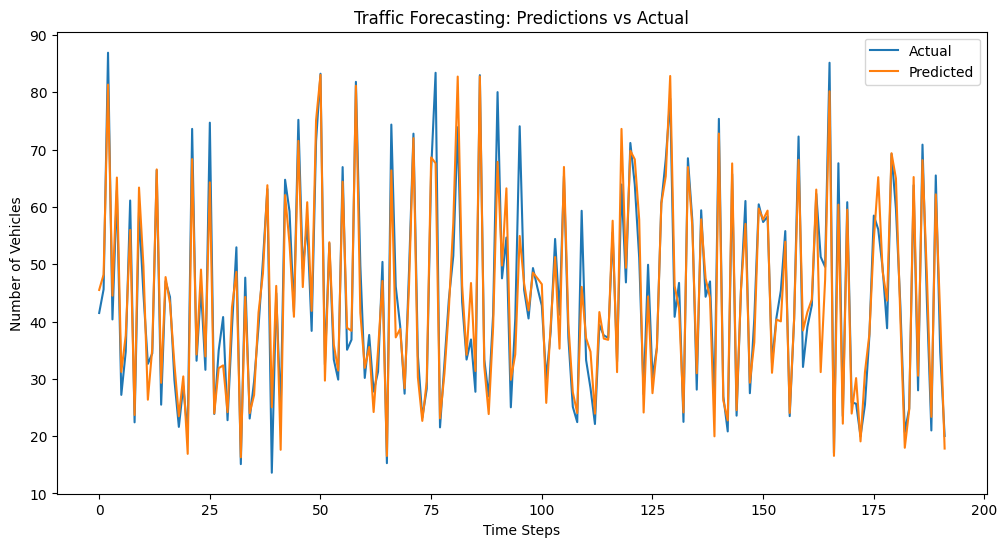

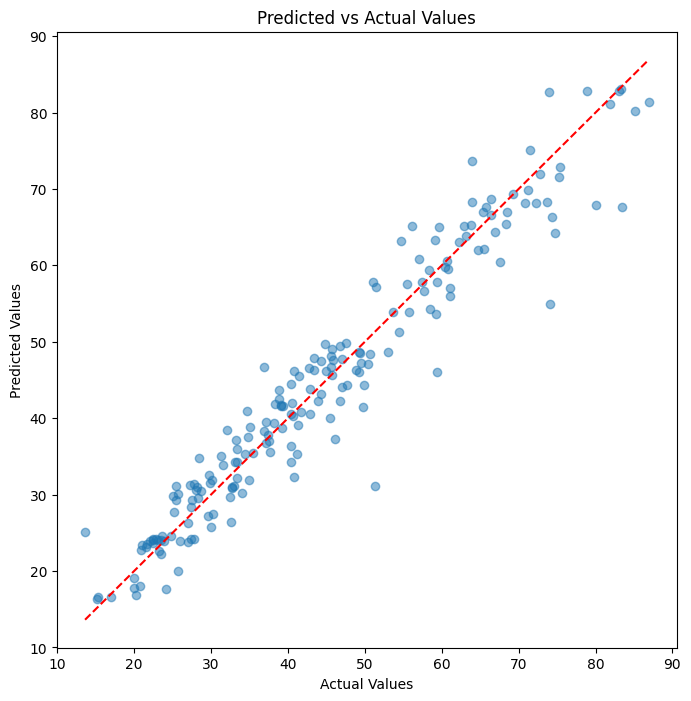

In [83]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    criterion = nn.MSELoss()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    test_mse = test_loss / len(test_loader)
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.4f}")

    # Convert to numpy arrays for plotting
    all_predictions = np.array(all_predictions).reshape(-1)
    all_targets = np.array(all_targets).reshape(-1)

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets, label='Actual')
    plt.plot(all_predictions, label='Predicted')
    plt.title('Traffic Forecasting: Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.show()

    # Plot scatter of predicted vs actual
    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_predictions, alpha=0.5)
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    return test_mse, all_predictions, all_targets

# First train the model and store it in a variable
#trained_model, train_mse = train_with_best_params(r_trainloader, input_size, output_size, lookback)

# Then test the model
test_mse, predictions, targets = test_model(trained_model, r_testloader)
